In [8]:
import torch
import numpy as np
from dataclasses import dataclass, field
from typing import List, Tuple

@dataclass
class Configs:
    #...general params:
    workdir : str = '../../results/mnist_test/'   
    device : str = 'cuda:0'
    multi_gpu : bool = False


    #...data params:
    target : str = 'digits'
    source : str = 'noise'
    dim_discrete : int = 1
    dim_context : int = 0
    vocab_size : int = 2
    input_shape : Tuple[float] = field(default_factory = lambda : (1, 28, 28))
    flat_image : bool = True

#...model params:
    model : str = 'mlp'
    num_layers : int = 4
    dim_hidden : int = 64 
    dim_time_emb : int = 16
    dim_discrete_emb : int = 16
    time_embedding  : str = 'kolmogorov-arnold'     
    dropout : float = 0.0
    activation : str = 'SELU'
    use_batch_norm : bool = False
    
    #...training params:
    batch_size : int = 128
    data_split_frac : List[float] = field(default_factory = lambda : [0.83334, 0.16667, 0.0])  # train / val / test 
    epochs: int = 100
    early_stopping : int = None
    min_epochs : int = None 
    print_epochs : int = None   
    num_workers : int = 0
    pin_memory: bool = False

    #...cjb params:
    dynamics : str = 'CJB'
    gamma: float = 0.01

    #...optimization & scheduler params:
    optimizer: str = 'Adam'
    lr : float = 2e-4
    weight_decay : float = 0.0
    optimizer_betas : List[float] = field(default_factory = lambda : [0.9, 0.999])
    optimizer_eps : float = 1e-8
    optimizer_amsgrad : bool = False
    gradient_clip : float = None
    scheduler: str = None
    scheduler_t_max: int = None
    scheduler_eta_min: float = None
    scheduler_gamma: float = None
    scheduler_step_size: int = None

    #...generation pipeline params:
    sampler : str = 'TauLeapingSolver'
    num_timesteps : int = 100
    time_eps : float = 1e-3


    def __post_init__(self):

        self.dim_discrete = np.prod(self.input_shape)
        self.data = self.source + '_to_' + self.target




# Data

In [9]:
from torchvision.transforms import ToPILImage
from cmb.data.binary_mnist import CouplingData

config = Configs()
images = CouplingData(config)
transform = ToPILImage()
pair = torch.cat([images.source.discrete[0].view(1, 28,28), images.target.discrete[0].view( 1, 28,28)], dim=1)
transform(pair)



# Train model

In [10]:
from cmb.models.architectures.classifiers import DiscreteStateMLP
from cmb.dynamics.cjb import ConditionalJumpBridge
from cmb.models.trainers import CMBTrainer

config = Configs()
images = CouplingData(config)
dynamics = ConditionalJumpBridge(config)
classifier = DiscreteStateMLP(config)
generative_model = CMBTrainer(dynamics, classifier, images)
generative_model.train()

number of training parameters: 2119584
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.83334/0.16667/0.0
INFO: train size: 58333, validation size: 11666, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

# Generate samples

In [11]:
import torch
from dataclasses import dataclass
import torchdyn
from torchdyn.core import NeuralODE


class Pipeline:
    def __init__(self, 
                 trained_model, 
                 config: dataclass=None,
                 best_epoch_model: bool=True
                 ):

        self.config = config
        self.model = trained_model.best_epoch_model if best_epoch_model else trained_model.last_epoch_model
        self.time_steps = torch.linspace(0.0, 1.0 - config.time_eps, config.num_timesteps)

    @torch.no_grad()
    def generate_samples(self, **source):
        
        if self.config.sampler == 'EulerSolver':
            solver = EulerSolver(model=self.model, config=self.config)
            paths = solver.simulate(time_steps=self.time_steps, **source)
            self.paths = paths.detach().cpu()

        if self.config.sampler == 'TauLeapingSolver':
            solver = TauLeapingSolver(model=self.model, config=self.config)
            jumps = solver.simulate(time_steps=self.time_steps, **source)
            self.jumps = jumps.detach().cpu()


class TauLeapingSolver:
    def __init__(self, model, config):
        self.model = model
        self.device = config.device
        self.dim_discrete = config.dim_discrete
        self.vocab_size = config.vocab_size 

    def simulate(self, time_steps, source_discrete, context=None, mask=None):
        k = source_discrete.to(self.device)
        time_steps = time_steps.to(self.device)
        context = context.to(self.device) if context is not None else None
        mask = mask.to(self.device) if mask is not None else None

        delta_t = (time_steps[-1] - time_steps[0]) / (len(time_steps) - 1)
        jumps = [k]

        for time in time_steps[1:]:
            time = torch.full((k.size(0), 1), time.item(), device=self.device)
            rates = self.model(t=time, k=k, context=context, output_rates=True).to(self.device)
            max_rate = torch.max(rates, dim=2)[1]
            all_jumps = torch.poisson(rates * delta_t).to(self.device) 
            mask =  torch.sum(all_jumps, dim=-1).type_as(k) <= 1
            diff = torch.arange(self.vocab_size, device=self.device).view(1, 1, self.vocab_size) - k[:,:, None]
            net_jumps = torch.sum(all_jumps * diff, dim=-1).type_as(k)
            k += net_jumps * mask
            k = torch.clamp(k, min=0, max=self.vocab_size-1)            
            jumps.append(k.clone())

        jumps = torch.stack(jumps)
        jumps[-1] = max_rate # replace last jump with max rates

        return jumps
    

class EulerSolver:
    def __init__(self, model, config):
        self.model = model # velocity field
        self.device = config.device

    def simulate(self, time_steps, source_continuous, context=None, mask=None):
        
        x = source_continuous.to(self.device)
        time_steps = time_steps.to(self.device)
        context = context.to(self.device) if context is not None else None
        mask = mask.to(self.device) if mask is not None else None
        
        delta_t = (time_steps[-1] - time_steps[0]) / (len(time_steps) - 1)
        paths = [x]

        for time in time_steps[1:]:
            time = torch.full((x.size(0), 1), time.item(), device=self.device)
            v = self.model(t=time, x=x, context=context, mask=mask).to(self.device)
            x += delta_t * v
            paths.append(x)
        
        paths = torch.stack(paths)

        return paths

In [12]:
num_samples = 16
pipeline = Pipeline(trained_model=generative_model, config=config)
input = CouplingData(config)
pipeline.generate_samples(source_discrete=input.source.discrete.long()[-num_samples:])


In [13]:
sample = pipeline.jumps.view(config.num_timesteps, num_samples, 1, 28, 28).float()
# k1 = pipeline.k1.view(num_samples, 1, 28, 28).float()


### MLP embedding (10 epochs)

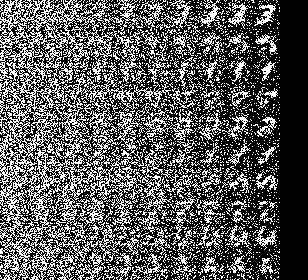

In [14]:
import random

from torchvision.transforms import ToPILImage

transform = ToPILImage()
generated_sample = []

boundary = torch

for idx in random.sample(range(0, num_samples), 10):
    img = []
    img1 = []
    
    for time_step in range(0, config.num_timesteps, 10):
        img.append(sample[time_step, idx,:,:,:]) 
    img.append(sample[-1, idx,:,:,:]) 
    # img.append(k1[idx,:,:,:])
    img = torch.cat(img, dim=-1)
    generated_sample.append(img)

generated_sample = torch.cat(generated_sample, dim=1)
transform(generated_sample)

### KAN embedding (10 epochs)

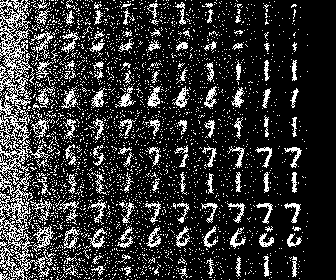

In [6]:
import random

from torchvision.transforms import ToPILImage

transform = ToPILImage()
generated_sample = []

boundary = torch

for idx in random.sample(range(0, num_samples), 10):
    img = []
    img1 = []
    
    for time_step in range(0, config.num_timesteps, 10):
        img.append(sample[time_step, idx,:,:,:]) 
    img.append(sample[-1, idx,:,:,:]) 
    img.append(k1[idx,:,:,:])
    img = torch.cat(img, dim=-1)
    generated_sample.append(img)

generated_sample = torch.cat(generated_sample, dim=1)
transform(generated_sample)